In [1]:
# The MIT License (MIT) Copyright (c) 2024 Emilio Morales
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of 
# this software and associated documentation files (the "Software"), to deal in the Software without 
# restriction, including without limitation the rights to use, copy, modify, merge, publish, 
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the 
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or 
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND 
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES 
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN 
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/milmor/NLP/blob/main/Notebooks/34_VQ-VAE.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# VQ-VAE

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

torch.__version__

'2.5.1+cu121'

In [3]:
torch.manual_seed(77)

## 1.- Dataset

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = 128

train_data = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, num_workers=4)

test_data = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                        shuffle=False, num_workers=4)

In [5]:
len(train_loader.dataset)

60000

In [6]:
test_batch, test_labels = next(iter(test_loader))
test_batch.shape, test_labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

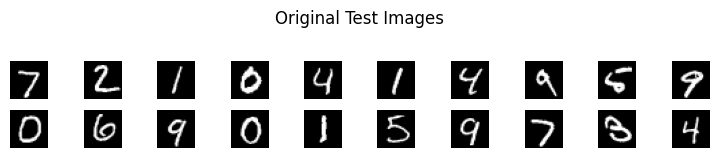

In [7]:
def plot_batch(images, title="Images"):
    fig, axes = plt.subplots(2, 10, figsize=(7.5, 1.5))
    axes = axes.flatten()

    for i in range(len(images)):
        axes[i].imshow(images[i].permute(1, 2, 0), cmap='gray')
        axes[i].axis('off')
    
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()

def plot_comparison(original, reconstructed, n=20):
    """Plot original and reconstructed images side by side"""
    fig, axes = plt.subplots(2, n, figsize=(n*0.75, 2))
    
    for i in range(n):
        # Original images (top row)
        axes[0, i].imshow(original[i].permute(1, 2, 0), cmap='gray')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Original', fontsize=10)
        
        # Reconstructed images (bottom row)
        axes[1, i].imshow(reconstructed[i].permute(1, 2, 0), cmap='gray')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Reconstructed', fontsize=10)
    
    plt.tight_layout()
    plt.show()

n = 20
batch_images = test_batch[:n]

plot_batch(batch_images, "Original Test Images")

## 2.- Model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VectorQuantizer(nn.Module):
    """
    Vector Quantization layer that quantizes continuous encoder outputs
    to discrete codes from a learnable codebook.
    """
    def __init__(self, num_embeddings, embedding_dim, commitment_cost=0.25):
        super(VectorQuantizer, self).__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.commitment_cost = commitment_cost
        
        # Initialize codebook (embedding table)
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
    
    def forward(self, inputs):
        # Flatten input: [B, C, H, W] -> [B*H*W, C]
        flat_input = inputs.view(-1, self.embedding_dim)
        
        # Calculate distances to codebook vectors
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self.embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self.embedding.weight.t()))
        
        # Find closest codebook vector (quantization)
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        
        # Get quantized vectors
        quantized = self.embedding(encoding_indices).view(inputs.shape)
        
        # Straight-through estimator: use quantized in forward, gradients through input
        quantized_st = inputs + (quantized - inputs).detach()
        
        # Calculate losses
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)  # Commitment loss
        q_latent_loss = F.mse_loss(quantized, inputs.detach())  # Codebook loss
        
        loss = q_latent_loss + self.commitment_cost * e_latent_loss
        
        # Preserve gradients for quantized_st
        quantized = quantized_st
        
        # Calculate perplexity (diversity of codebook usage)
        avg_probs = torch.histc(encoding_indices.float(), bins=self.num_embeddings, 
                                min=0, max=self.num_embeddings-1).float()
        avg_probs = avg_probs / torch.sum(avg_probs)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        return quantized, loss, perplexity, encoding_indices


class VQVAE(nn.Module):
    def __init__(self, image_channels=1, num_embeddings=512, embedding_dim=128, z_ch=128):
        super(VQVAE, self).__init__()
        self.z_ch = z_ch
        self.embedding_dim = embedding_dim
        assert embedding_dim == z_ch, "embedding_dim must match z_ch"
        
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), # output is 7x7
        )
        self.encoder_fc = nn.Sequential(
            nn.Linear(64*7*7, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, self.z_ch*7*7),
            nn.ReLU()
        )
        
        # Vector Quantization layer
        self.vq = VectorQuantizer(num_embeddings, embedding_dim)
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(self.z_ch, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        conv_output = self.encoder_conv(x)
        conv_output = conv_output.view(conv_output.size(0), -1)
        z_e = self.encoder_fc(conv_output)
        z_e = z_e.view(z_e.shape[0], self.z_ch, 7, 7)
        return z_e
    
    def quantize(self, z_e):
        # Quantize the continuous encoder output
        z_q, vq_loss, perplexity, encoding_indices = self.vq(z_e)
        return z_q, vq_loss, perplexity, encoding_indices
    
    def decode(self, z_q):
        reconstructed = self.decoder_conv(z_q)
        return reconstructed
    
    def forward(self, x):
        z_e = self.encode(x)
        z_q, vq_loss, perplexity, encoding_indices = self.quantize(z_e)
        reconstructed = self.decode(z_q)
        return reconstructed, vq_loss, perplexity, encoding_indices
        
        
num_embeddings = 512  # Size of codebook
embedding_dim = 128   # Dimension of each codebook vector (must match z_ch=128)
vqvae = VQVAE(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
rec_batch, vq_loss, perplexity, indices = vqvae(test_batch)
rec_batch.shape

torch.Size([128, 1, 28, 28])

In [9]:
# Let's visualize the quantization process step by step
print("=== Quantization Process Visualization ===\n")

# Get a single test image
single_image = test_batch[0:1]  # [1, 1, 28, 28]
print(f"1. Input image shape: {single_image.shape}")

# Encode
z_e = vqvae.encode(single_image)
print(f"2. Encoder output (continuous) shape: {z_e.shape}")
print(f"   - Batch: {z_e.shape[0]}, Channels: {z_e.shape[1]}, Spatial: {z_e.shape[2]}×{z_e.shape[3]}")
print(f"   - Total vectors to quantize: {z_e.shape[2] * z_e.shape[3]} = {z_e.shape[2]*z_e.shape[3]}")
print(f"   - Each vector is {z_e.shape[1]}-dimensional (continuous values)")

# Show codebook info
print(f"\n3. Codebook:")
print(f"   - Shape: {vqvae.vq.embedding.weight.shape} = [num_embeddings, embedding_dim]")
print(f"   - {vqvae.vq.num_embeddings} learnable vectors, each {vqvae.vq.embedding_dim}-dimensional")
print(f"   - These are the 'discrete codes' we can choose from")

# Quantize
z_q, vq_loss, perplexity, encoding_indices = vqvae.quantize(z_e)
print(f"\n4. Quantized output shape: {z_q.shape}")
print(f"   - Same shape as encoder output, but values come from codebook")

# Show encoding indices
indices_flat = encoding_indices.view(-1)
print(f"\n5. Encoding indices (which codebook vectors were used):")
print(f"   - Shape: {encoding_indices.shape}")
print(f"   - Flattened: {indices_flat.shape}")
print(f"   - First 10 indices: {indices_flat[:10].squeeze().tolist()}")
print(f"   - These are indices (0-{vqvae.vq.num_embeddings-1}) pointing to codebook vectors")
print(f"   - Unique codes used: {len(torch.unique(indices_flat))} out of {vqvae.vq.num_embeddings}")

# Show the actual quantization
print(f"\n6. Quantization example (first spatial location):")
first_vec_e = z_e[0, :, 0, 0]  # First vector from encoder
first_idx = indices_flat[0].item()
first_vec_q = z_q[0, :, 0, 0]  # Corresponding quantized vector
print(f"   Encoder output: {first_vec_e[:5].tolist()}... (continuous)")
print(f"   Codebook index: {first_idx}")
print(f"   Quantized vector: {first_vec_q[:5].tolist()}... (from codebook)")
print(f"   Difference (quantization error): {torch.norm(first_vec_e - first_vec_q).item():.4f}")

# Decode
reconstructed = vqvae.decode(z_q)
print(f"\n7. Reconstructed image shape: {reconstructed.shape}")
print(f"\n8. Perplexity: {perplexity.item():.2f}")
print(f"   - Measures codebook diversity (higher = more codes used)")
print(f"   - Max possible: {vqvae.vq.num_embeddings} (if all codes used equally)")
print(f"   - Current: {perplexity.item():.2f} means ~{perplexity.item():.0f} codes are actively used")

=== Quantization Process Visualization ===

1. Input image shape: torch.Size([1, 1, 28, 28])
2. Encoder output (continuous) shape: torch.Size([1, 128, 7, 7])
   - Batch: 1, Channels: 128, Spatial: 7×7
   - Total vectors to quantize: 49 = 49
   - Each vector is 128-dimensional (continuous values)

3. Codebook:
   - Shape: torch.Size([512, 128]) = [num_embeddings, embedding_dim]
   - 512 learnable vectors, each 128-dimensional
   - These are the 'discrete codes' we can choose from

4. Quantized output shape: torch.Size([1, 128, 7, 7])
   - Same shape as encoder output, but values come from codebook

5. Encoding indices (which codebook vectors were used):
   - Shape: torch.Size([49, 1])
   - Flattened: torch.Size([49])
   - First 10 indices: [439, 232, 88, 92, 441, 507, 441, 285, 201, 508]
   - These are indices (0-511) pointing to codebook vectors
   - Unique codes used: 34 out of 512

6. Quantization example (first spatial location):
   Encoder output: [0.0, 0.0, 0.026422161608934402, 0

## 3.- Training

In [10]:
from torch import optim

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [12]:
vqvae.to(device)

VQVAE(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (encoder_fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Linear(in_features=256, out_features=6272, bias=True)
    (6): ReLU()
  )
  (vq): VectorQuantizer(
    (embedding): Embedding(512, 128)
  )
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3)

Epoch 0, Loss: 571.5261, Recon: 0.2714, VQ: 571.2547, Perplexity: 1.00

Reconstruction comparison at epoch 0:


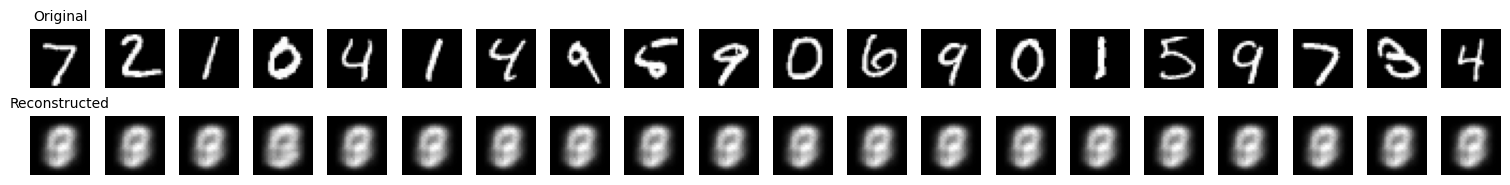

Epoch 5, Loss: 60.9781, Recon: 0.2204, VQ: 60.7577, Perplexity: 2.99
Epoch 10, Loss: 4.8030, Recon: 0.1399, VQ: 4.6631, Perplexity: 7.74

Reconstruction comparison at epoch 10:


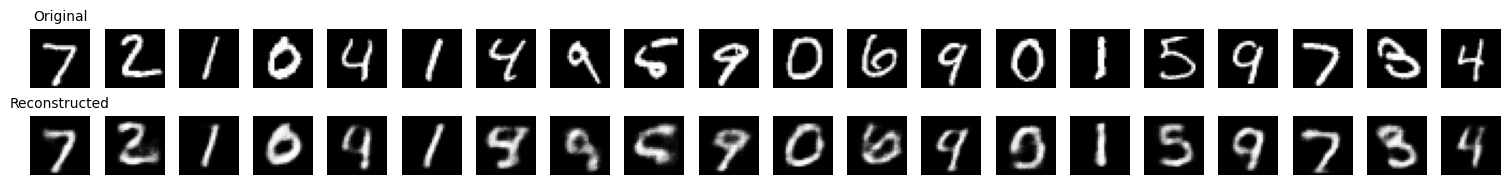

Epoch 15, Loss: 0.9412, Recon: 0.1062, VQ: 0.8350, Perplexity: 48.02
Epoch 20, Loss: 0.4261, Recon: 0.0986, VQ: 0.3275, Perplexity: 85.64

Reconstruction comparison at epoch 20:


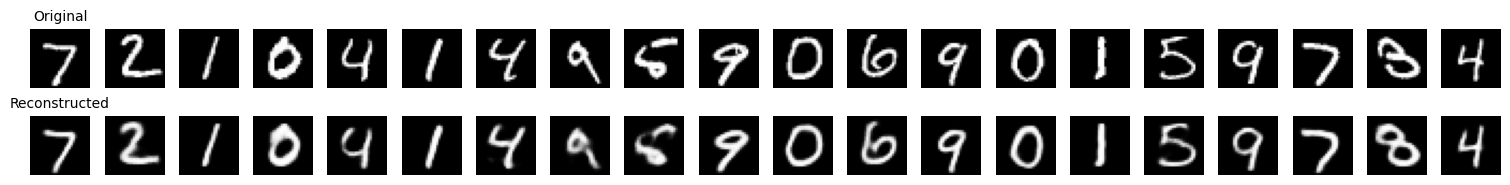

Epoch 25, Loss: 0.3260, Recon: 0.0918, VQ: 0.2341, Perplexity: 99.65
Epoch 30, Loss: 0.3057, Recon: 0.0891, VQ: 0.2166, Perplexity: 104.87

Reconstruction comparison at epoch 30:


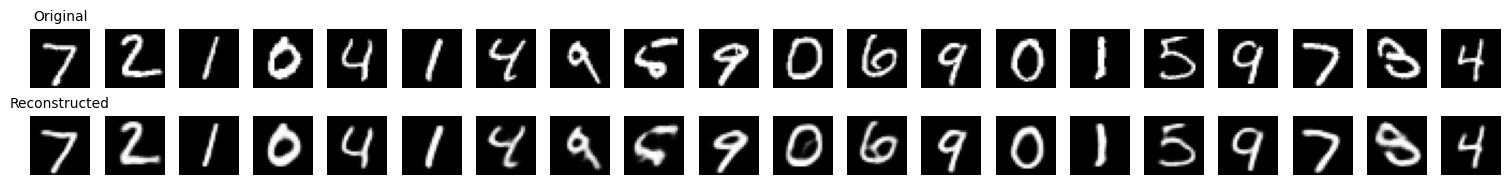

In [13]:
lr = 1e-3
num_epochs = 30
reconstruction_loss = nn.BCELoss(reduction='mean')
optimizer = optim.Adam(vqvae.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-5)

epoch_inter = 10

for epoch in range(num_epochs + 1):
    for images, _ in train_loader:
        images = images.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # Forward pass
        reconstructed, vq_loss, perplexity, encoding_indices = vqvae(images)
        
        # Reconstruction loss (mean over batch and pixels)
        recon_loss = reconstruction_loss(reconstructed, images)
        # Total loss: reconstruction + vector quantization loss
        loss = recon_loss + vq_loss

        loss.backward()
        optimizer.step()

    if epoch % 5 == 0 or epoch == num_epochs:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}, Recon: {recon_loss.item():.4f}, VQ: {vq_loss.item():.4f}, Perplexity: {perplexity.item():.2f}')

    if epoch % epoch_inter == 0:
        with torch.no_grad():
            rec_batch, vq_loss, perplexity, indices = vqvae(test_batch.to(device))
            print(f"\nReconstruction comparison at epoch {epoch}:")
            plot_comparison(test_batch[:n], rec_batch[:n].detach().cpu(), n=n)

## 4.- Inference

=== VQ-VAE Inference:

This demonstrates how to use a trained VQ-VAE model for inference.

1. Loading 10 test images
   - Input shape: torch.Size([10, 1, 28, 28])
   - Labels: [7, 2, 1, 0, 4, 1, 4, 9, 5, 9]

2. Running inference (forward pass)...
3. Quantization Process Details:

   a) Encoder output (continuous):
      - Shape: torch.Size([10, 128, 7, 7])
      - Total spatial locations: 49 per image
      - Total vectors to quantize: 490

   b) Quantization results:
      - Quantized shape: torch.Size([10, 128, 7, 7])
      - Encoding indices shape: torch.Size([490, 1])
      - Unique codes used: 123 out of 512
      - Code usage distribution:
        Top 5 most used codes:
          Code 5: used 13 times (2.7%)
          Code 0: used 12 times (2.4%)
          Code 33: used 11 times (2.2%)
          Code 16: used 10 times (2.0%)
          Code 22: used 10 times (2.0%)

   c) Example: First image quantization
      - Encoding indices map (7×7):
        [[ 70 100 471  51  25   7  90]
 

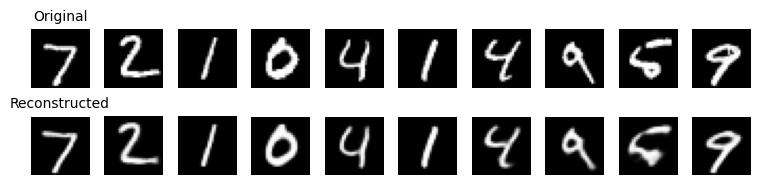

In [14]:
print("=== VQ-VAE Inference:\n")
print("This demonstrates how to use a trained VQ-VAE model for inference.\n")

vqvae.eval()

# Get a batch of test images
test_images, test_labels = next(iter(test_loader))
test_images = test_images.to(device)
n_inference = 10  # Number of images to process

print(f"1. Loading {n_inference} test images")
print(f"   - Input shape: {test_images[:n_inference].shape}")
print(f"   - Labels: {test_labels[:n_inference].tolist()}\n")

print("2. Running inference (forward pass)...")
with torch.no_grad():  
    reconstructed, vq_loss, perplexity, encoding_indices = vqvae(test_images[:n_inference])

print("3. Quantization Process Details:")
print("   " + "="*60)

# Encode to get continuous latents
z_e = vqvae.encode(test_images[:n_inference])
print(f"\n   a) Encoder output (continuous):")
print(f"      - Shape: {z_e.shape}")
print(f"      - Total spatial locations: {z_e.shape[2] * z_e.shape[3]} per image")
print(f"      - Total vectors to quantize: {z_e.shape[0] * z_e.shape[2] * z_e.shape[3]}")

# Quantize
z_q, vq_loss_detail, perplexity_detail, encoding_indices_detail = vqvae.quantize(z_e)
indices_flat = encoding_indices_detail.view(-1)

print(f"\n   b) Quantization results:")
print(f"      - Quantized shape: {z_q.shape}")
print(f"      - Encoding indices shape: {encoding_indices_detail.shape}")
print(f"      - Unique codes used: {len(torch.unique(indices_flat))} out of {vqvae.vq.num_embeddings}")
print(f"      - Code usage distribution:")
unique, counts = torch.unique(indices_flat, return_counts=True)
top_5_indices = torch.argsort(counts, descending=True)[:5]
print(f"        Top 5 most used codes:")
for i, idx in enumerate(top_5_indices):
    code_idx = unique[idx].item()
    usage_count = counts[idx].item()
    usage_pct = (usage_count / len(indices_flat)) * 100
    print(f"          Code {code_idx}: used {usage_count} times ({usage_pct:.1f}%)")

print(f"\n   c) Example: First image quantization")
# Reshape encoding_indices from [B*H*W, 1] to [B, H, W]
batch_size = z_e.shape[0]
h, w = z_e.shape[2], z_e.shape[3]
encoding_indices_grid = encoding_indices_detail.view(batch_size, h, w)
first_image_indices = encoding_indices_grid[0]  # Get first image [7, 7]
print(f"      - Encoding indices map (7×7):")
print(f"        {first_image_indices.cpu().numpy()}")
print(f"      - Each number is a codebook index (0-{vqvae.vq.num_embeddings-1})")

print("\n" + "="*60)

print("\n4. Visualizing Results:")
print("   Showing original vs reconstructed images...")

test_images_cpu = test_images[:n_inference].cpu()
reconstructed_cpu = reconstructed.cpu()
plot_comparison(test_images_cpu, reconstructed_cpu, n=n_inference)

- Quantization converts continuous latents to discrete codes
- Each image is represented by 49 discrete codes (7×7 spatial grid)
- These codes can be stored/transmitted efficiently (49 integers per image)

=== Working with Discrete Codes ===

One key advantage of VQ-VAE: you can extract and manipulate discrete codes!

1. Discrete Code Representation:
   - Input: 5 images of shape [1, 28, 28] = 3920 pixels
   - Encoded to: 5 code grids of shape [7, 7] = 245 codes
   - Compression ratio: 16.0x
   - Each code is an integer (0-511)

2. Example: Discrete codes for first image:
   Code grid (7×7):
[[ 70 100 471  51  25   7  90]
 [  5  12  22 418  66  72   8]
 [ 68  53  93   1  74  14  40]
 [ 83 103  65  91  10 104  88]
 [ 24   9  90  52 357  61 115]
 [ 30  39  31  40   3  12   7]
 [ 82  94  20   1  61  77  76]]

   This represents the image as 49 discrete codes

3. Reconstructing from codes:
Reconstruct images directly from discrete codes:


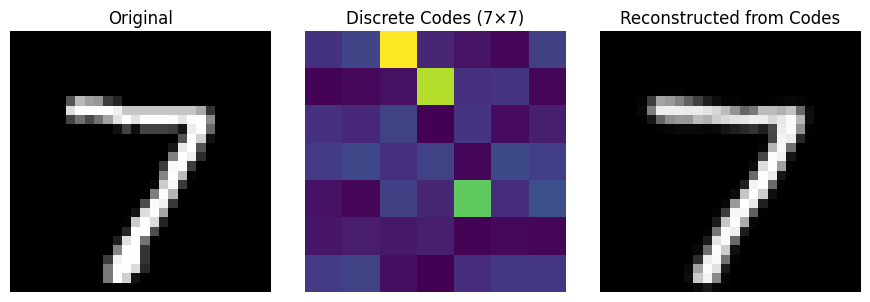

In [15]:
# Additional: Working with Discrete Codes
print("=== Working with Discrete Codes ===\n")
print("One key advantage of VQ-VAE: you can extract and manipulate discrete codes!\n")

# Extract discrete codes for a batch of images
with torch.no_grad():
    z_e = vqvae.encode(test_images[:5])
    z_q, _, _, encoding_indices = vqvae.quantize(z_e)

# Reshape indices to spatial grid
encoding_indices_grid = encoding_indices.view(5, 7, 7)

print("1. Discrete Code Representation:")
print(f"   - Input: 5 images of shape [1, 28, 28] = {5 * 28 * 28} pixels")
print(f"   - Encoded to: 5 code grids of shape [7, 7] = {5 * 7 * 7} codes")
print(f"   - Compression ratio: {(5 * 28 * 28) / (5 * 7 * 7):.1f}x")
print(f"   - Each code is an integer (0-{vqvae.vq.num_embeddings-1})\n")

print("2. Example: Discrete codes for first image:")
print(f"   Code grid (7×7):")
print(encoding_indices_grid[0].cpu().numpy())
print(f"\n   This represents the image as 49 discrete codes\n")

print("3. Reconstructing from codes:")
print("Reconstruct images directly from discrete codes:")
with torch.no_grad():
    # Get codebook vectors for the codes
    codes_flat = encoding_indices_grid[0].view(-1)  # Flatten to [49]
    z_q_from_codes = vqvae.vq.embedding(codes_flat)  # Look up in codebook
    z_q_from_codes = z_q_from_codes.view(1, vqvae.z_ch, 7, 7)  # Reshape
    reconstructed_from_codes = vqvae.decode(z_q_from_codes)


# Visualize
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(test_images[0].cpu().permute(1, 2, 0), cmap='gray')
axes[0].set_title('Original', fontsize=12)
axes[0].axis('off')

axes[1].imshow(encoding_indices_grid[0].cpu().numpy(), cmap='viridis')
axes[1].set_title('Discrete Codes (7×7)', fontsize=12)
axes[1].axis('off')

axes[2].imshow(reconstructed_from_codes[0].cpu().permute(1, 2, 0), cmap='gray')
axes[2].set_title('Reconstructed from Codes', fontsize=12)
axes[2].axis('off')

plt.tight_layout()
plt.show()

- Image compression: Store only 49 integers instead of 784 pixels
- Transfer learning: Use discrete codes as features for other tasks
- Generation: Train a prior model (e.g., PixelCNN) over the discrete codes
- Manipulation: Edit codes directly to modify images